## Load Library

In [59]:
import pandas as pd

from datasets import load_dataset
import re
import tqdm

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Visualization
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

## Load Dataset

In [2]:
dataset = load_dataset('datasets/20231101-wikipedia.id', split='train')

In [8]:
dataset[0]

{'id': '1',
 'url': 'https://id.wikipedia.org/wiki/Asam%20deoksiribonukleat',
 'title': 'Asam deoksiribonukleat',
 'text': 'Asam deoksiribonukleat, lebih dikenal dengan singkatan DNA (bahasa Inggris: deoxyribonucleic acid), adalah salah satu jenis asam nukleat yang memiliki kemampuan pewarisan sifat. Keberadaan asam deoksiribonukleat ditemukan di dalam nukleoprotein yang membentuk inti sel. James Dewey Watson dan Francis Crick merupakan ilmuwan pertama yang mengajukan model struktur DNA pada tahun 1953 dengan bentuk pilinan ganda. Setiap DNA tersusun dari dua buah rantai polinukleotida. DNA merupakan sejenis biomolekul yang menyimpan dan menyandi instruksi-instruksi genetika setiap organisme dan banyak jenis virus. Instruksi-instruksi genetika ini berperan penting dalam pertumbuhan, perkembangan, dan fungsi organisme dan virus. DNA merupakan asam nukleat; bersamaan dengan protein dan karbohidrat, asam nukleat adalah makromolekul esensial bagi seluruh makhluk hidup yang diketahui. Keban

In [38]:
df = dataset.to_pandas().sample(5000)

In [39]:
df.iloc[0]

id                                                  663265
url      https://id.wikipedia.org/wiki/Ramban%20Timur%2...
title                      Ramban Timur, Cermee, Bondowoso
text     Ramban Timur merupakan salah satu desa di Keca...
Name: 148286, dtype: object

In [40]:
df.to_csv('datasets/data_used.csv')

## Cleaning

In [4]:
def clean_text(text):
    result = text.lower()
    result = re.sub(r'[^\w\s\.,%\-]+', ' ', result) # Remove Symbol
    result = re.sub(r'[_]+', ' ', result) # Remove Underscore
    # Remove space between digit and symbol (1 - 2, 1 %)
    result = re.sub(r'([\d]+)[\s]*(%)', r'\1 persen ', result) # Change % to 'persen'
    result = re.sub(r'([\d]+)[\s]*-[\s]*([\d]+)', r'\1 hingga \2 ', result) # Change 'a - b' to 'a hingga b'
    result = re.sub(r'[Cc]ovid[\s]*-[\s]*19', r'covid 19', result) # Special case for Covid-19
    result = re.sub(r'-[\s]*([\d]+)', r' negatif \1', result) # Change '-a' to 'negatif a'
    result = re.sub(r'([\D])[\.,]+', r'\1 ', result) # Remove dot and comma (exceeding)
    result = re.sub(r'[\.,]+([\D])', r'\1 ', result) # Remove dot and comma (preceeding)
    result = re.sub(r'([\D])[%]+', r'\1 ', result) # Remove Percent
    result = re.sub(r'([\D])-+([\D])', r'\1 \2', result) # Remove Strip
    result = re.sub(r'[\s]+', ' ', result) # Remove Multiple Whitespace
    result = result.strip()
    return result

In [41]:
tqdm.tqdm.pandas()

df['text_clean'] = df['text'].progress_apply(lambda x : clean_text(x))

100%|██████████| 5000/5000 [00:02<00:00, 1919.73it/s]


In [42]:
df.iloc[0]

id                                                       663265
url           https://id.wikipedia.org/wiki/Ramban%20Timur%2...
title                           Ramban Timur, Cermee, Bondowoso
text          Ramban Timur merupakan salah satu desa di Keca...
text_clean    ramban timur merupakan salah satu desa di keca...
Name: 148286, dtype: object

In [43]:
df.to_csv('datasets/data_clean.csv')

## Stemming

In [69]:
def stem(text_ : str):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return stemmer.stem(text_)

In [83]:
tqdm.tqdm.pandas()

df['text_stemmed'] = df['text_clean'].progress_apply(lambda x : stem(x))

100%|██████████| 5000/5000 [01:50<00:00, 45.16it/s]


In [84]:
df.iloc[0]

id                                                              663265
url                  https://id.wikipedia.org/wiki/Ramban%20Timur%2...
title                                  Ramban Timur, Cermee, Bondowoso
text                 Ramban Timur merupakan salah satu desa di Keca...
text_clean           ramban timur merupakan salah satu desa di keca...
text_stemmed         ramban timur rupa salah satu desa di camat cer...
text_stemmed_stop    ramban timur salah desa camat cermee kabupaten...
Name: 0, dtype: object

In [85]:
df.to_csv('datasets/stemmed/data_sastrawi.csv')

## Stopword

In [86]:
df = pd.read_csv('datasets/stemmed/data_sastrawi.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,id,url,title,text,text_clean,text_stemmed,text_stemmed_stop
0,663265,https://id.wikipedia.org/wiki/Ramban%20Timur%2...,"Ramban Timur, Cermee, Bondowoso",Ramban Timur merupakan salah satu desa di Keca...,ramban timur merupakan salah satu desa di keca...,ramban timur rupa salah satu desa di camat cer...,ramban timur salah desa camat cermee kabupaten...
1,3405898,https://id.wikipedia.org/wiki/Punggok%20kokodok,Punggok kokodok,"Punggok kokodok (Ninox boobook), dikenal di be...",punggok kokodok ninox boobook dikenal di beber...,punggok kokodok ninox boobook kenal di beberap...,punggok kokodok ninox boobook daerah mopoke sp...
2,1210013,https://id.wikipedia.org/wiki/2012%20CA53,2012 CA53,2012 CA53 adalah sebuah asteroid. Asteroid ini...,2012 ca53 adalah sebuah asteroid asteroid ini ...,2012 ca53 adalah buah asteroid asteroid ini ru...,2012 ca53 asteroid asteroid asteroid amor leta...
3,3344775,https://id.wikipedia.org/wiki/Marc%20Esposito,Marc Esposito,Marc Esposito () adalah seorang sutradara dan ...,marc esposito adalah seorang sutradara dan pen...,marc esposito adalah orang sutradara dan tulis...,marc esposito sutradara tulis naskah prancis e...
4,232236,https://id.wikipedia.org/wiki/Massimo%20Troisi,Massimo Troisi,Massimo Troisi (19 Februari 1953-4 Juni 1994) ...,massimo troisi 19 februari 1953 hingga 4 juni ...,massimo troisi 19 februari 1953 hingga 4 juni ...,massimo troisi 19 februari 1953-4 juni 1994 ak...


In [87]:
stopword = StopWordRemoverFactory()
add_stopword = ['tahun',
                'referensi',
                'pranala',
                'ke',
                'bentuk',
                'kembang',
                'milik',
                'buah',
                'hasil',
                'kenal',
                'nama']

stopword_list = stopword.get_stop_words()
stopword_list.extend(add_stopword)

In [88]:
def remove_stopword(text_):
    result = []
    for i in text_.split():
        if i not in stopword_list:
            result.append(i)

    return " ".join(result)

In [89]:
tqdm.tqdm.pandas()

df['text_stemmed_stop'] = df['text_stemmed'].progress_apply(lambda x: remove_stopword(x))

100%|██████████| 5000/5000 [00:10<00:00, 469.36it/s]


{'indonesia': 1.0, 'salah': 0.9807692307692307, 'kota': 0.9379370629370629, 'perintah': 0.8645104895104895, 'utama': 0.833041958041958, 'amerika serikat': 0.8111888111888111, 'tinggal': 0.7867132867132867, 'raja': 0.7814685314685315, 'usaha': 0.7683566433566433, 'temu': 0.7674825174825175, 'sejarah': 0.7631118881118881, 'bangun': 0.743006993006993, 'tuli': 0.7342657342657343, 'negatif': 0.7316433566433567, 'umum': 0.6896853146853147, 'jalan': 0.6826923076923077, 'negara': 0.6748251748251748, 'main': 0.6538461538461539, 'pimpin': 0.6197552447552448, 'dasar': 0.6145104895104895, 'film': 0.6057692307692307, 'lahir': 0.5708041958041958, 'wilayah': 0.5568181818181818, 'tingkat': 0.548951048951049, 'sepak bola': 0.5367132867132867, 'golong famili': 0.5340909090909091, 'pilih': 0.5332167832167832, 'abad negatif': 0.5270979020979021, 'ganti': 0.5096153846153846, 'waktu': 0.49213286713286714, 'kingdom animalia': 0.48513986013986016, 'masyarakat': 0.48426573426573427, 'hubung': 0.481643356643356

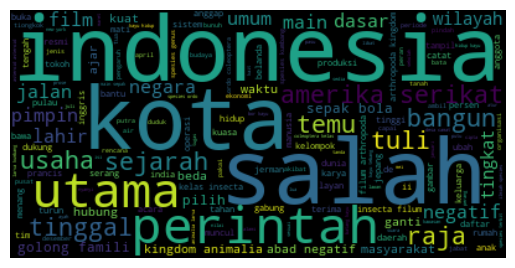

In [90]:
# Start with one review:
text = " ".join([_ for _ in df['text_stemmed_stop']])

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
print(wordcloud.words_)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [91]:
df.to_csv('datasets/stopword/data_sastrawi.csv')